<a href="https://colab.research.google.com/github/pockerman/hidden_markov_modeling/blob/master/stories/story_15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Story 29


### Region 3 [40000000-60000000] chr2

In [1]:
import sys
sys.path.append("../")

In [2]:
import numpy as np
from pomegranate import *
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from helpers import read_configuration_file, INFO, WARNING
from train import load_regions
from hmm_helpers import build_hmm
from helpers import WindowType
from preprocess_utils import get_distributions_list_from_names as get_dist_list
from region import Region

In [4]:
from notebooks_helpers import filter_viterbi_path
from notebooks_helpers import save_segments
from notebooks_helpers import load_data_file
from notebooks_helpers import get_start_end_segment
from notebooks_helpers import make_data_array
from notebooks_helpers import gmm_clustering
from notebooks_helpers import create_viterbi_path
from notebooks_helpers import create_states
from notebooks_helpers import create_tuf_state
from notebooks_helpers import get_states_counter
from notebooks_helpers import plot_hmm_states_to_labels
from notebooks_helpers import plot_hmm_label_state
from notebooks_helpers import plot_hmm_cluster_contours

In [5]:
sns.set(color_codes=True)

Apply ```HMM_Model_9.json``` in region ```region_0_REGION_3_CHR_2_MEAN_CUTOFF.txt``` [40000000-60000000]

Orphan state HMM_Model-start removed due to no edges                             leading to it
Orphan state HMM_Model-end removed due to no edges                             leading to it


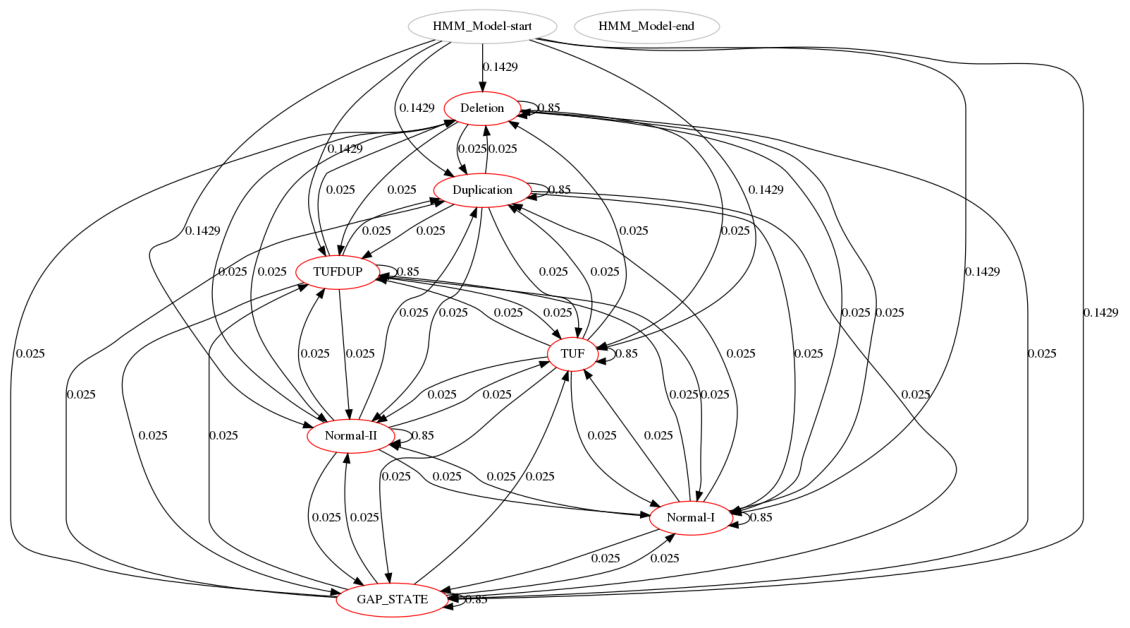

In [6]:
# load the configuration
configuration = read_configuration_file("../config.json")
hmm_config = configuration["HMM"]
hmm_filename = "HMM_Model_9.json"
hmm_model = build_hmm(hmm_file=hmm_filename)
# visualize the model we just trained
plt.figure( figsize=(20,18) )
hmm_model.plot()
plt.show()

In [7]:
# load the region we want to use for prediction
region_name = "region_0_REGION_3_CHR_2_MEAN_CUTOFF.txt"
region_file = "/home/alex/qi3/hidden_markov_modeling/data/" + region_name 
region = Region.load(filename=region_file)
region.check_windows_sanity()
mixed_windows = region.get_mixed_windows()

# load a sequence including the gaps
sequence = region.get_region_as_rd_mean_sequences_with_windows(size=None,
                                                               window_type=WindowType.from_string(hmm_config["train_windowtype"]),
                                                                n_seqs=hmm_config["train_n_sequences_per_source"],
                                                                exclude_gaps=False)

print("Sequence length: ", len(sequence))

INFO: Loading region from file: /home/alex/qi3/hidden_markov_modeling/data/region_0_REGION_3_CHR_2_MEAN_CUTOFF.txt
Sequence length:  200000


In [8]:
filename="viterbi_path_" + region_name
viterbi_path, observations, sequence_viterbi_state = create_viterbi_path(sequence=sequence, 
                                                                         hmm_model=hmm_model, filename=filename)

Observation length:  200000
Done. Execution time 0.7553629689973604 secs
Log-probability of ML Viterbi path:  -1354019.7416512843
Viterbi path length:  200001
There should be 0 gaps


In [11]:
# extract the tuf + Deletion + tuf
tuf_delete_tuf = filter_viterbi_path(path=viterbi_path[1][1:],
                                    wstate='TUF', limit_state='Deletion',
                                    min_subsequence=1)

print("Length of TUF+DELETION+TUF state: ", len(tuf_delete_tuf))

segments = get_start_end_segment(tuf_delete_tuf, sequence)

filename="tuf_delete_tuf_" + region_name
save_segments(segments=segments, chromosome='chr1', filename=filename)

Length of path  200000
Length of TUF+DELETION+TUF state:  186


In [9]:
wga_obs = []
no_wga_obs = []
no_gaps_obs = []

for obs in observations:
    
    # do not account for gaps
    if obs != (-999.0, -999.0):
        wga_obs.append(obs[0])
        no_wga_obs.append(obs[1])
        no_gaps_obs.append((obs[1], obs[0]))
 
print("Length of WGA Observations: ", len(wga_obs))
print("Encountered gaps: ", len(observations) - len(wga_obs))
nbins = 80

Length of WGA Observations:  200000
Encountered gaps:  0


In [10]:
states_counter = {"Duplication": 0, "Normal-I": 0, "Normal-II":0, 
                  "Deletion": 0, "Single-Deletion": 0, "TUF": 0,
                  "GAP_STATE": 0, "GAP_STATE_INCORRECT":0, 'TUFDUP':0}

states_counter, state_data = get_states_counter(states_counter=states_counter,
                                   observations=observations,
                                   sequence_viterbi_state=sequence_viterbi_state)
print(states_counter) 

{'Duplication': 70, 'Normal-I': 147229, 'Normal-II': 52048, 'Deletion': 57, 'Single-Deletion': 0, 'TUF': 596, 'GAP_STATE': 0, 'GAP_STATE_INCORRECT': 0, 'TUFDUP': 0}


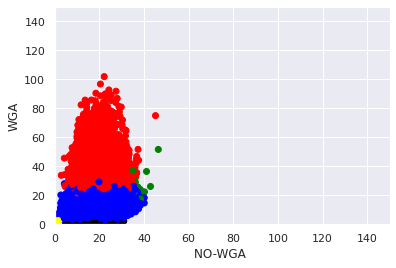

HMM labels color:  {'blue': [1, 147229], 'red': [2, 52048], 'black': [5, 596], 'yellow': [3, 57], 'green': [0, 70]}


In [11]:
hmm_states_to_labels = {"Duplication": 0, "Normal-I": 1, "Normal-II":2, 
                        "Deletion": 3, "Single-Deletion": 4, "TUF": 5, "TUFDUP":6}

color_comp_assoc_hmm, hmm_states_to_labels, hmm_labels = \
plot_hmm_states_to_labels(hmm_states_to_labels=hmm_states_to_labels,
                          observations=observations, 
                          sequence_viterbi_state=sequence_viterbi_state, 
                          no_wga_obs=no_wga_obs, wga_obs=wga_obs, 
                          xlim=(0.0, 150.), ylim=(0.0, 150.0))
print("HMM labels color: ", color_comp_assoc_hmm)

In [12]:
for state in state_data:
    print("State: ", state)
    
    if len(state_data[state][0]) == 0:
        continue
    
    print("WGA mean/var: ", np.mean(state_data[state][0]), np.var(state_data[state][0]))
    print("NO-WGA mean/var: ", np.mean(state_data[state][1]), np.var(state_data[state][1]))

State:  Duplication
WGA mean/var:  26.264428571428578 24.619118959183673
NO-WGA mean/var:  34.066857142857145 10.874787265306121
State:  Normal-I
WGA mean/var:  16.550845689368263 23.433626585816764
NO-WGA mean/var:  18.99082354699142 21.521726490330902
State:  Normal-II
WGA mean/var:  31.053852789732552 59.95896693244842
NO-WGA mean/var:  19.57594816323394 19.559321595606836
State:  Deletion
WGA mean/var:  1.846842105263158 1.900291782086796
NO-WGA mean/var:  1.8649122807017546 1.4492670975684825
State:  Single-Deletion
State:  TUF
WGA mean/var:  2.5769630872483225 2.267403025483086
NO-WGA mean/var:  15.621778523489933 24.40040489054547
State:  GAP_STATE
State:  GAP_STATE_INCORRECT
State:  TUFDUP


State:  Duplication
Length: 70


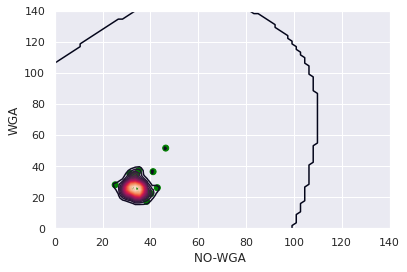

State:  Normal-I
Length: 147229


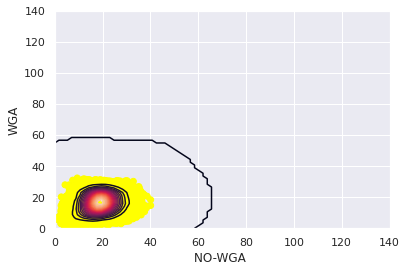

State:  Normal-II
Length: 52048


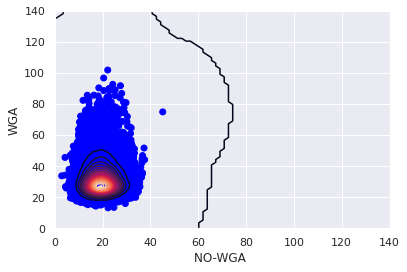

State:  Deletion
Length: 57


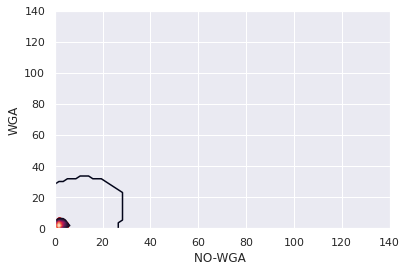

State:  Single-Deletion
For state: Single-Deletion could not plot empty observations
State:  TUF
Length: 596


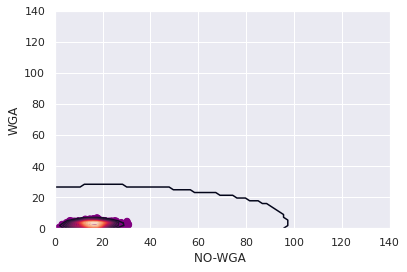

State:  TUFDUP
For state: TUFDUP could not plot empty observations


In [15]:
plot_hmm_label_state(hmm_states_to_labels=hmm_states_to_labels, hmm_labels=hmm_labels, 
                     no_wga_obs=no_wga_obs, wga_obs=wga_obs, nbins=80, xlim=(0.0, 140.),ylim=(0.0, 140.))

State:  Deletion
[[0.970271600267186, 0.958137372653406], [[1.1036072543648185, 0.0], [0.0, 1.1932036611641303]]]
State:  Duplication
[[24.283621138294365, 55.0], [[39.473393085057296, 0.0], [0.0, 71.53462337717849]]]
State:  Normal-I
[[13.750290519035646, 16.65535114027298], [[19.019257854346822, 0.0], [0.0, 31.488140792022595]]]
State:  Normal-II
[[40.0, 19.641842481040367], [[52.49115328954019, 0.0], [0.0, 19.606180750829882]]]
State:  TUF
[[1.7345118994138116, 14.220278071386755], [[1.9260086547849433, 0.0], [0.0, 15.655595281606255]]]
[[1.7345118994138116, 40.0], [[1.9260086547849433, 0.0], [0.0, 28.60670595671783]]]
Weights found:  [-0.69314718 -0.69314718]
Weights:  [0.5 0.5]
State:  TUFDUP
[[1.7345118994138116, 85.0], [[1.9260086547849433, 0.0], [0.0, 93.36225933227568]]]
state:  TUF
state:  Deletion
state:  Duplication
state:  Normal-I
state:  Normal-II
state:  TUFDUP


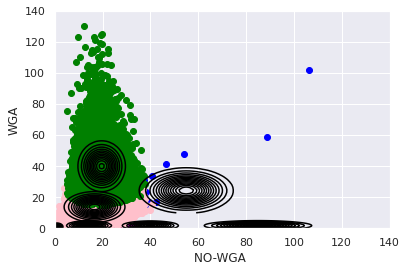

In [14]:
obs_state = {}

for state in hmm_states_to_labels:
    obs_state[state] = []

for i, obs in enumerate(observations):
        if obs != (-999.0, -999.0):
            viterbi_state = sequence_viterbi_state[i][1]
            obs_state[viterbi_state].append(obs)
            
states = hmm_model.states

state_vars = {}

for state in states:
    
    if state.name in hmm_states_to_labels:
        
        print("State: ", state.name)
        
        if state.distribution.name == "MultivariateGaussianDistribution":
            print(state.distribution.parameters)
            
            state_vars[state.name] = state.distribution.parameters
            
        elif state.name == 'TUF':
            
            state_vars[state.name] = {}
           
            for i, comp in enumerate(state.distribution.distributions):
                state_vars[state.name]["comp"+str(i)] = comp.parameters
                print(comp.parameters)
            weights = state.distribution.weights
            print("Weights found: ", weights)
            state_vars[state.name]["weights"] = np.exp(weights) 
            print("Weights: ", state_vars[state.name]["weights"])


state_colors={'TUF':"purple", "Deletion":"red",
                'Duplication':"blue", "Normal-I":"pink",
                "Normal-II":"green",
             'TUFDUP':'magenta'}

state_min_max = {'TUF':{'min_x': 0.0, 'max_x':140.0, 'min_y': 0.0, 'max_y':10.0},
                 'TUFDUP':{'min_x': 40.0, 'max_x':140.0, 'min_y': 0.0, 'max_y':10.0},
                 'Deletion':{'min_x': 0.0, 'max_x':10.0, 'min_y': 0.0, 'max_y':10.0},
                 'Normal-II':{'min_x': 0.0, 'max_x':45.0, 'min_y': 0.0, 'max_y':140.0},
                 'Normal-I':{'min_x': 0.0, 'max_x':45.0, 'min_y': 0.0, 'max_y':35.0},
                 'Duplication':{'min_x': 20.0, 'max_x':140.0, 'min_y': 10.0, 'max_y':140.0}}

plot_hmm_cluster_contours(state_colors=state_colors, state_vars=state_vars, 
                          obs_state=obs_state, nbins=80, ncontours=14, state_min_max=state_min_max)

In [16]:
wga_mean_file = "/home/alex/qi3/hidden_markov_modeling/data/wga_windows_mean_0_REGION_3_CHR_2_MEAN_CUTOFF.txt"
no_wga_mean_file = "/home/alex/qi3/hidden_markov_modeling/data/no_wga_windows_mean_0_REGION_3_CHR_2_MEAN_CUTOFF.txt"

In [17]:
wga_mu = load_data_file(filename=wga_mean_file)
no_wga_mu = load_data_file(filename=no_wga_mean_file)

In [18]:
data = make_data_array(wga_mu=wga_mu, 
                       no_wga_mu=no_wga_mu, gc=None, 
                       use_ratio=False, use_gc=False)

data = np.array(data)

assert data.shape == (len(wga_mu), 2)

Number of clusters  5
Converged:  True
BIC:  2567116.5584738827
Len of labels:  200000


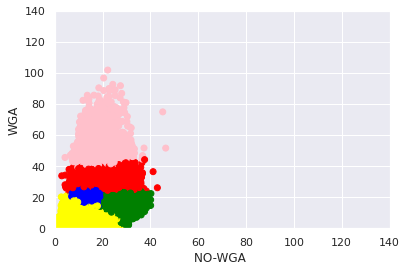

Color-cluster association {'red': [2, 44174], 'blue': [1, 52630], 'green': [0, 54758], 'yellow': [3, 42962], 'pink': [4, 5476]}


In [19]:
gmm, labels, color_comp_assoc = gmm_clustering(clusters=5, data=data, tol=1.0e-5, 
                                                 cov_type='diag',
                                                 max_itrs=500, n_init=1,
                                                 no_wga_mu=no_wga_mu, wga_mu=wga_mu,
                                                 xlim=(0., 140.0),
                                                 ylim=(0., 140.0))

print("Color-cluster association", color_comp_assoc)

In [20]:
means = gmm.means_

for comp in color_comp_assoc:
    print("Component {0} means {1}".format(comp, means[color_comp_assoc[comp][0]]))

#for i in range(len(means)):
#    print("{0} Component {1} means {2} ".format(INFO, i , means[i]))

covariances = gmm.covariances_

Component red means [20.04826463 27.2725782 ]
Component blue means [17.67228    19.41135715]
Component green means [21.65039513 17.49582179]
Component yellow means [16.51732789 12.28089912]
Component pink means [19.13779196 36.77355607]
